### Forecasting future value of Apple Stock Using Time Series Analysis - ARIMA

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats.mstats import normaltest
from matplotlib.pyplot import acorr
%matplotlib inline
import quandl 
from pandas.core import datetools

Lets collect data of Apple stock for 8 years to forecast future value of the stock using time series analysis.

In [34]:
quandl.ApiConfig.api_key = 'QPMeL2L_kSvf2WMw9Esx'
APPLE = quandl.get_table('WIKI/PRICES', ticker='AAPL')
APPLE.to_csv('APPLE.csv')
lastAPPLE = APPLE[-1:]
APPLE = APPLE[:-1]
APPLE.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
None,,,,,,,,,,,,,,
0,AAPL,1980-12-12,28.75,28.87,28.75,28.75,2093900.0,0.0,1.0,0.422706,0.424470,0.422706,0.422706,117258400.0
1,AAPL,1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,0.402563,0.402563,0.400652,0.400652,43971200.0
2,AAPL,1980-12-16,25.37,25.37,25.25,25.25,472000.0,0.0,1.0,0.373010,0.373010,0.371246,0.371246,26432000.0
3,AAPL,1980-12-17,25.87,26.00,25.87,25.87,385900.0,0.0,1.0,0.380362,0.382273,0.380362,0.380362,21610400.0
4,AAPL,1980-12-18,26.63,26.75,26.63,26.63,327900.0,0.0,1.0,0.391536,0.393300,0.391536,0.391536,18362400.0


In [37]:
# Lets take Log of the daily the closing value to ensures that level induced volatility does not interfere with the stationarity of series.


APPLE['date']= APPLE.index
APPLE['APPLE']= APPLE.close
APPLE['logAPPLE']= np.log(APPLE['APPLE'])
APPLE['diflogAPPLE'] = APPLE['logAPPLE'] - APPLE['logAPPLE'].shift(periods=-1)
APPLE = APPLE.dropna()

Text(0.5,0,'Month')

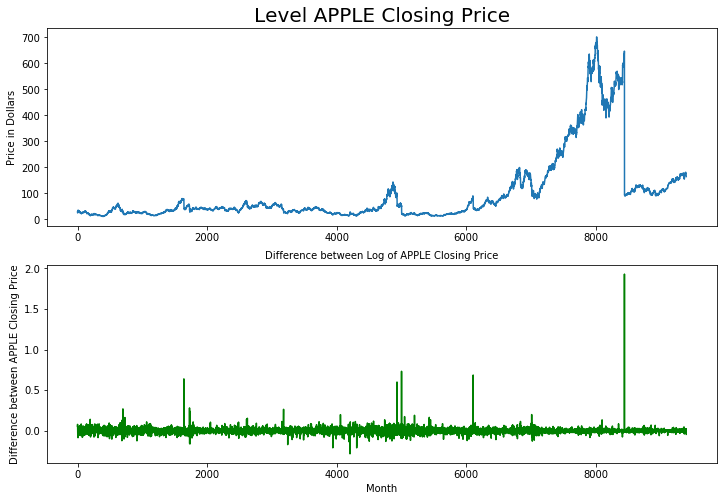

In [27]:
# As we are interested in the day to day change of the stock prices, we take the difference of the closing values. This differencing is another way to get the time series to be stationary.

fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(APPLE.date, APPLE.APPLE, label = "Log of APPLE Closing Price")
plt.title("Level APPLE Closing Price", size = 20,)
plt.ylabel("Price in Dollars", size = 10)

plt.subplot(2, 1, 2)
plt.plot(APPLE.date, APPLE.diflogAPPLE, label = '1st Diffrence of Log of APPLE', color = 'g')
plt.title("Difference between Log of APPLE Closing Price", size = 10,)
plt.ylabel("Difference between APPLE Closing Price", size = 10)
plt.xlabel('Month', size = 10)

For reliable forecasting, we need stationary series. Therefore performing Dickey-Fuller test helps us to detect whether the series is stationary or not. Smaller the p-value, more stationary will be the series.

In [28]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(APPLE.diflogAPPLE, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -48.466910
p-value                           0.000000
# Lags Used                       3.000000
Number of Observations Used    9394.000000
Critical Value (1%)              -3.431046
Critical Value (5%)              -2.861848
Critical Value (10%)             -2.566934
dtype: float64


Lets implement time series analysis model: ARIMA (Auto-Regressive-Integrated-Moving-Average).

The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors, i.e -

Predicted value of Y = a constant and/or a weighted sum of one or more recent values of Y and/or a weighted sum of one or more recent values of the errors.

In [39]:
ararray = (APPLE.logAPPLE.dropna().as_matrix())
p=0
q=0
d=1
pdq=[]
aic=[]

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
            
keys = pdq
values = aic
d = dict(zip(keys, values))
minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]
print ("Best model is :", (p,d,q))
ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()

(0, 1, 0) -35099.886866869485
(0, 1, 1) -35101.230969210694
(0, 1, 2) -35101.64383210399


/Users/ishanverma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/ishanverma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


(1, 1, 0) -35101.11846559505
(1, 1, 1) -35099.9457710158
(2, 1, 0) -35101.95138811556
(2, 1, 1) -35100.949059648454
Best model is : (2, 1, 0)


In [38]:
numofsteps = 1
stepahead = ARIMIAmod.forecast(numofsteps)[0]
ferrors = ARIMIAmod.forecast(numofsteps)[2]
ferrors
print ('%s Steps ahead forecast value is:' % numofsteps, np.exp(stepahead))
print ('%s Steps Ahead 95 percent CI is:' % numofsteps, np.exp(ferrors[0]))
print ('March 27, 2018 Close (most recent): %s ' % lastAPPLE.close)

1 Steps ahead forecast value is: [164.93869506]
1 Steps Ahead 95 percent CI is: [153.29198995 177.4702849 ]
March 27, 2018 Close (most recent): None
9398    172.77
Name: close, dtype: float64 
